## Data Loading and EDA

Loading Data and EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes

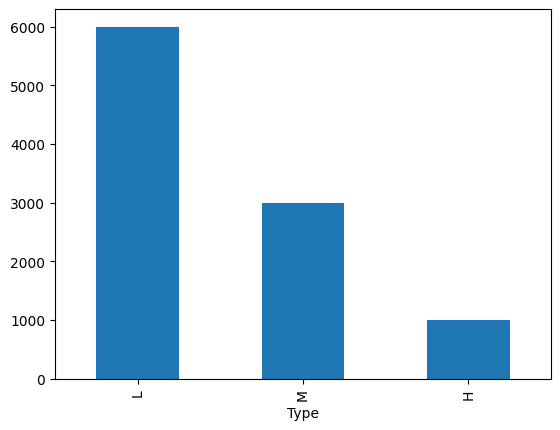

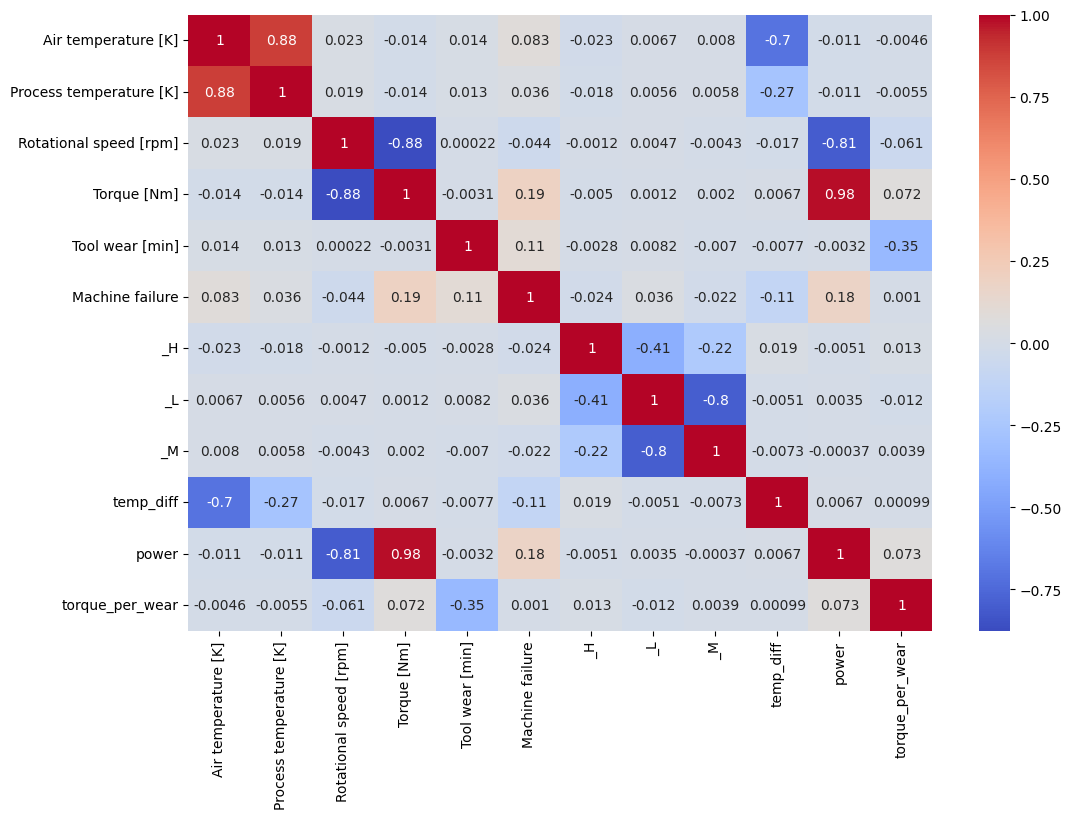

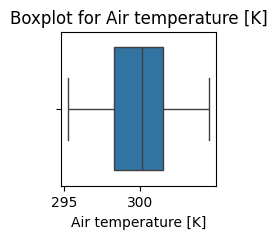

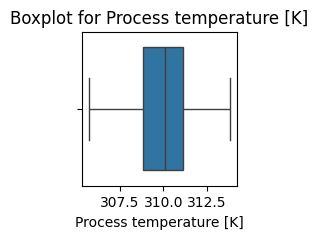

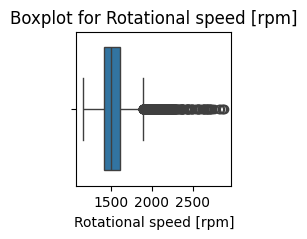

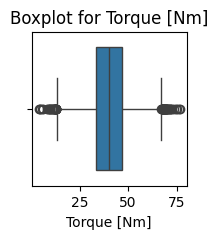

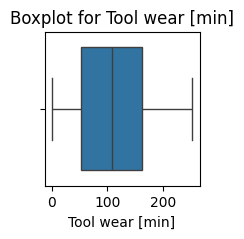

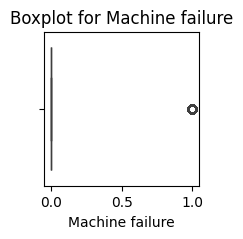

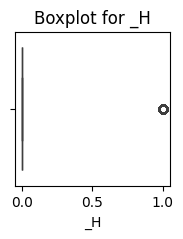

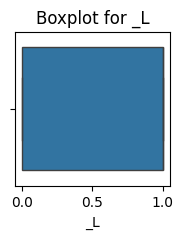

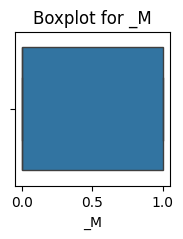

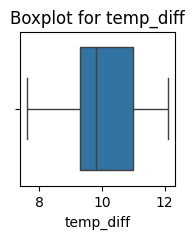

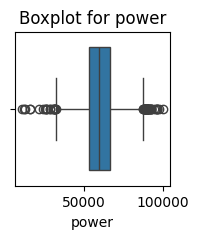

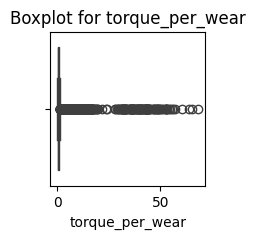

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading Data and EDA\n")

data = pd.read_csv('pred_maintenance.csv')
print(f"'Head'\n{data.head()}\n\n'Info'\n{data.info()}\n\n'Description'\n{data.describe()}\n\n'Null Values?'\n{data.isnull().sum()}\n\n'Unique Values'\n{data.nunique()}\n\n'Duplicates?'\n{data.duplicated().sum()}")

print("Bar Plot for all the values in the column 'Type'\n")
data['Type'].value_counts().plot(kind='bar')


print("One-Hot-Encoded the 'Type' Column\nRemoved the not-required Column\n")
data_encoded = pd.get_dummies(data, columns=['Type'], prefix="", dtype='int')
new_data = data_encoded.copy()
new_data = new_data.drop(['Product ID', 'UDI','TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
new_data['temp_diff'] = new_data['Process temperature [K]'] - new_data['Air temperature [K]']
new_data['power'] = new_data['Torque [Nm]'] * new_data['Rotational speed [rpm]']
new_data['torque_per_wear'] = new_data['Torque [Nm]'] / (new_data['Tool wear [min]'] + 1)
print(f"{new_data.head()}")


print("Correlation Matrix")
plt.figure(figsize=(12, 8))
sns.heatmap(new_data.corr(), annot=True, cmap='coolwarm')


print("Looking for Outliers using Boxplot")
for column in new_data.columns:
    plt.figure(figsize=(2, 2))
    sns.boxplot(x=new_data[column])
    plt.title(f'Boxplot for {column}')
    plt.show()
    print("\n")

## XGBoost Training

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x, y = new_data.drop('Machine failure', axis=1), new_data['Machine failure']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_resampled, y_resampled = SMOTE(random_state=42).fit_resample(x_train_scaled, y_train)

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=6,
    learning_rate=0.03,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.3,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit(x_resampled, y_resampled)

y_proba = xgb_model.predict_proba(x_test_scaled)[:, 1]
optimal_threshold = 0.95
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))
print("Accuracy: ",accuracy_score(y_test, y_pred_custom))
print("Precision: ",precision_score(y_test, y_pred_custom))
print("Recall: ",recall_score(y_test, y_pred_custom))
print("F1-Score: ",f1_score(y_test, y_pred_custom))
print("ROC-AUC-SCORE: ",roc_auc_score(y_test, y_pred_custom))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0     0.9917    0.9943    0.9930      1932
           1     0.8254    0.7647    0.7939        68

    accuracy                         0.9865      2000
   macro avg     0.9086    0.8795    0.8935      2000
weighted avg     0.9861    0.9865    0.9863      2000

Accuracy:  0.9865
Precision:  0.8253968253968254
Recall:  0.7647058823529411
F1-Score:  0.7938931297709924
ROC-AUC-SCORE:  0.8795061502862015


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score

x, y = new_data.drop('Machine failure', axis=1), new_data['Machine failure']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_resampled, y_resampled = SMOTE(random_state=42).fit_resample(x_train_scaled, y_train)

param_grid = {
    'scale_pos_weight': [1, 2, 5, 6, 10, 15, 20, 28]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.3,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_resampled, y_resampled)

print("Best scale_pos_weight:", grid_search.best_params_['scale_pos_weight'])

best_model = grid_search.best_estimator_

y_proba = best_model.predict_proba(x_test_scaled)[:, 1]
optimal_threshold = 0.95
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:", recall_score(y_test, y_pred_custom))
print("F1-Score:", f1_score(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_custom))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:50:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best scale_pos_weight: 2
Classification Report:
              precision    recall  f1-score   support

           0     0.9908    0.9984    0.9946      1932
           1     0.9434    0.7353    0.8264        68

    accuracy                         0.9895      2000
   macro avg     0.9671    0.8669    0.9105      2000
weighted avg     0.9891    0.9895    0.9889      2000

Accuracy: 0.9895
Precision: 0.9433962264150944
Recall: 0.7352941176470589
F1-Score: 0.8264462809917356
ROC-AUC: 0.8668706613080015


## Saving the Model

In [ ]:
import joblib
joblib.dump(xgb_model, 'xgb_machine_failure_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']